**This notebook was developed with the assistance of ChatGPT and Claude Gen AI tools. The student used the tools as a tutor to guide him in the task that needs to be achieved, how it will be achieved, and what achieving it will look like.**

**This note book relies on 96x96x3 padded .png files which are located on the students personal Google Drive. See the related assignment paper for access to the original data via git repo**

# **0. Admin**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, regularizers, callbacks, Model
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
import numpy as np

In [4]:
!unzip "/content/drive/MyDrive/Sem2/COS801/Assignment1/train_96pad.zip" -d /content/data
!unzip "/content/drive/MyDrive/Sem2/COS801/Assignment1/test_96pad.zip" -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train_96pad/Charlock/c6368b901.png  
  inflating: /content/data/train_96pad/Charlock/c7ac56c83.png  
  inflating: /content/data/train_96pad/Charlock/c836af21e.png  
  inflating: /content/data/train_96pad/Charlock/c842c829b.png  
  inflating: /content/data/train_96pad/Charlock/c8b44af53.png  
  inflating: /content/data/train_96pad/Charlock/c911db696.png  
  inflating: /content/data/train_96pad/Charlock/c9601d3ab.png  
  inflating: /content/data/train_96pad/Charlock/c97f86135.png  
  inflating: /content/data/train_96pad/Charlock/c9a504525.png  
  inflating: /content/data/train_96pad/Charlock/ca1aaeb27.png  
  inflating: /content/data/train_96pad/Charlock/ca8f0f871.png  
  inflating: /content/data/train_96pad/Charlock/caa43063c.png  
  inflating: /content/data/train_96pad/Charlock/cb142c018.png  
  inflating: /content/data/train_96pad/Charlock/cdbf55495.png  
  inflating: /content/data/train_96pad/Charlock/ce547

# **1. Input and Splits**

In [5]:
# 1.1 Load Directories with data to vars
TRAIN_DIR = "/content/data/train_96pad"   # folder with 12 class subfolders
TEST_DIR  = "/content/data/test_96pad"    # flat folder or subfolders

In [6]:
# 1.2 Pipeline Hyperparameters
IMG_SIZE  = (96, 96)
BATCH     = 32 # Size of batch sent to model (i.e - , no. images)
SEED      = 42 # Maintains randomness
VAL_SPLIT = 0.15 # Validation split = 15%

In [7]:
pip install tensorflow

In [8]:
# 1.3 Load TRAIN + VAL from folder structure
# Tensorflow has feature that allows it to detect subfolder names and use them as labels for incoming data
# training data is stored in a Dataset - train_ds, same with validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, # Extracts ALL images in the directory. Uses the subfolder the image is found in as a label
    validation_split=VAL_SPLIT,
    subset="training", # This ensures val splits on 85% as this is training data
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",   # Uses one-hot encoding for labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
)

Found 4750 files belonging to 12 classes.
Using 4038 files for training.
Found 4750 files belonging to 12 classes.
Using 712 files for validation.


In [9]:
#1.4 Load TEST (no labels expected)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode=None,            # unlabeled
    shuffle=False               # keep order for mapping preds to files
)

Found 794 files.


In [10]:
# 1.5 Pre CNN loading admin
# Normalization to [0,1] Same scaling of pixel values to improve processing
normalizer = layers.Rescaling(1./255)

# Brightness: ~±10% via a small Lambda wrapper (tf.image.random_brightness)
def random_brightness(x):
    # delta ~ ±0.10 in [0,1] space; clip back to [0,1]
    x = tf.image.random_brightness(x, max_delta=0.10)
    return tf.clip_by_value(x, 0.0, 1.0)

# Augmentation (train-only).
augment = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", seed=SEED), # Flips: both directions (plants are largely orientation invariant)
        layers.RandomRotation(0.10, seed=SEED), # Rotation: ~±10%
        layers.RandomZoom(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10), seed=SEED), # Zoom: ±10% (both H and W)
        layers.RandomContrast(0.10, seed=SEED), # Contrast: ±10%
        layers.Lambda(random_brightness, name="RandomBrightness"), # Random brightness
    ],
    name="data_augmentation",
)

# Autotune model parameters while training
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
# 1.6 Data preparation
# This prep_train(ds) function is a TensorFlow data pipeline that takes a dataset ds (your training set) and applies normalization, augmentation, shuffling, and prefetching so it’s ready for the CNN.
def prep_train(ds):
    return (
        ds.map(lambda x, y: (normalizer(x), y), num_parallel_calls=AUTOTUNE)  # Takes each (x = image, y = label) pair from the dataset. Applies normalizer(x) to the image (x) → scales pixel values to [0, 1]
          .map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE) # Passes the normalized image through your augmentation pipeline (augment).
          .shuffle(buffer_size=len(ds)*BATCH, seed=SEED, reshuffle_each_iteration=True) # Randomly shuffles the dataset so the model sees images in a different order each epoch. Prevents the model from memorizing image order.
          .prefetch(AUTOTUNE) # While the model is training on one batch, the next batch is prepared in the background. Keeps the GPU busy instead of waiting for the CPU to load/process images.
    )

# Prepare validation and data -> normalise pixels only. Do not augement validation data
def prep_eval(ds):
    # val/test: normalize only (NO augmentation)
    return ds.map(lambda x, *y: (normalizer(x),) + y, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# The *y is the neat trick:
#   - For validation, elements look like (x, y) → *y is (y,), so the lambda returns (normalized_x, y).
#   - For test (often unlabeled), elements are just x → *y is empty (), so the lambda returns (normalized_x,).

You absolutely should apply the same resizing + padding to your test data.

Here’s why:

1️⃣ Test data must still be in the same format as training data

Your CNN expects inputs of fixed size and format — for example, 96×96 RGB.
If your training set images are resized to that size, but your test images are not, you’ll get:

Shape mismatch errors when feeding into the model

Or worse, garbage predictions because the scale and proportions are inconsistent.

So we preprocess test data in the exact same way as training data — same resizing, padding, normalization — so the model can evaluate them fairly.

2️⃣ “Unseen” means labels & content, not preprocessing

The point of test data is that the model hasn’t learned from those specific examples.
It doesn’t mean the raw pixels can’t be resized or normalized — that’s just standard preparation so they fit through the model.

Think of it like:

You train a car-recognition AI on cleanly formatted license plate photos (all same dimensions),
you still need to crop & resize the new plates you test it on — otherwise the AI can’t “read” them properly.

3️⃣ Keep the resizing process consistent

If you resize training data to 96×96 with padding, do the exact same process for test data:

Same target size

Same padding color

Same RGB conversion

Same resampling filter (e.g., LANCZOS)

That way, the test results are directly comparable to the training results.

✅ Summary rule:

Always apply the same preprocessing steps to training, validation, and test sets.
What must differ is the content, not the formatting.

If you want, I can tweak the script I gave you so it automatically processes both train and test folders in one run while keeping their outputs separate.
That way you don’t need to run it twice.

# **2. Hyperprams**

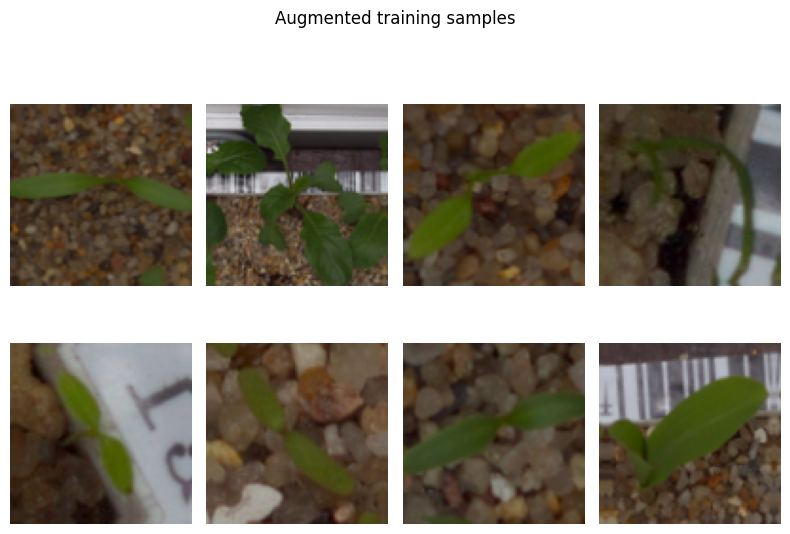

In [12]:
# 2.1 Prepare 3 ready to use datasets
train_ds_aug = prep_train(train_ds)
val_ds_norm  = prep_eval(val_ds)
test_ds_norm = prep_eval(test_ds)

# Precheck training data augmentation before running CNN
if __name__ == "__main__":
    for batch, labels in train_ds_aug.take(1):
        plt.figure(figsize=(8, 6))
        for i in range(8):
            ax = plt.subplot(2, 4, i+1)
            plt.imshow(batch[i].numpy())
            plt.axis("off")
        plt.suptitle("Augmented training samples")
        plt.tight_layout()
        plt.show()

✅ So what you see:
A grid of 8 training images that have been augmented (maybe flipped, rotated, zoomed, brightened/contrasted).
This helps confirm:

Your augmentations are working.

They make sense (no over-aggressive transformations that ruin labels).

Images are being read and normalized properly.

In [13]:
# 2.2 CNN Hyperparameters
LR = 1e-3
'''
Meaning: Learning rate = 0.001.
Why it matters: Controls how big each weight update step is when backpropagating.
  Too high → unstable training, loss may bounce around or diverge.
  Too low → training is very slow, may get stuck in local minima.
Why 1e-3: This is a common safe default for Adam optimizer. You can later reduce it (e.g., 1e-4) when fine-tuning or if validation loss plateaus.
'''

WD = 1e-4
'''
(Weight Decay / L2 Regularization)
Meaning: Adds a penalty term = sum(weights^2) * 1e-4 to the loss.
Why it matters: Prevents weights from growing too large, which reduces overfitting.
Think of it as a “gravity pull” keeping weights small and generalizable.
Why 1e-4: Strong enough to regularize, but not so strong that it “shrinks” everything to near-zero (which would underfit).
'''

DROP = 0.4
'''
(Dropout Rate)
Meaning: At training time, randomly zeroes out 40% of the neurons in that layer.
Why it matters: Forces the network to not rely too much on any one neuron, improving generalization.
  Too high (e.g., 0.7) → model may underfit.
  Too low (e.g., 0.1) → not enough regularization.
Why 0.4: Mid-range, often works well for fully-connected layers. (0.3–0.5 is standard.)
'''

EPOCHS = 20
'''
Meaning: Maximum number of full passes through the dataset.
Why it matters:
  More epochs → model learns more, but risk of overfitting.
  Fewer epochs → model might underfit (stop too soon).
Why 20: A safe starting point. With EarlyStopping, you don’t actually train all 20 — it will stop earlier if val_loss stops improving.
'''

NUM_CLASSES = len(train_ds.class_names)
'''
Meaning: Number of distinct plant species in your dataset (12 in your case).
Why it matters: Defines the output layer size of the softmax classifier.
  If you had 5 classes → Dense(5, softmax).
  For 12 species → Dense(12, softmax).
Why dynamic: Using len(train_ds.class_names) ensures code is future-proof if dataset changes.
'''

kernelSize = 3 # Note: kernel has  3 dims - H x W x D. First conv, D = RGD, thereafter, D = No kernals out from previous conv

actFunction = "relu"

noKernels = 32
'''
🔹 Why multiple filters?
Imagine plant classification 🌿:
  Filter 1 → highlights leaf edges.
  Filter 2 → highlights veins.
  Filter 3 → highlights textures.
  … until Filter 32 → captures 32 unique “ways of looking” at the same plant image.
The next layer then combines these 32 feature maps into higher-level patterns (e.g., combinations of textures and edges).

✅ So in short:
A filter is a tiny sliding weight matrix.
Each filter detects one kind of pattern.
32 filters means the CNN learns 32 different patterns in that layer.
'''

'\n🔹 Why multiple filters?\nImagine plant classification 🌿:\n  Filter 1 → highlights leaf edges.\n  Filter 2 → highlights veins.\n  Filter 3 → highlights textures.\n  … until Filter 32 → captures 32 unique “ways of looking” at the same plant image.\nThe next layer then combines these 32 feature maps into higher-level patterns (e.g., combinations of textures and edges).\n\n✅ So in short:\nA filter is a tiny sliding weight matrix.\nEach filter detects one kind of pattern.\n32 filters means the CNN learns 32 different patterns in that layer.\n'

🔹 1. Learning Rate (LR)

Too high (e.g., 1e-2 = 0.01):

Loss curve: jumps up and down like a rollercoaster 🎢, maybe never converges.

Accuracy: stuck ~30–40% because updates overshoot the “valley” of the loss function.

Too low (e.g., 1e-5 = 0.00001):

Loss curve: slowly creeps down, almost flat ⏳.

Accuracy: may stay at ~50–60% even after many epochs — model is “learning in slow motion.”

Just right (1e-3):

Loss curve: steady downward slope, small oscillations.

Accuracy: climbs steadily to 75–80% (what you saw).

🔹 2. Weight Decay (WD)

None (0):

Loss curve: drops fast at first, but validation loss may climb later → overfitting.

Accuracy: training accuracy much higher than validation (gap opens wide).

Too strong (1e-2):

Loss curve: goes down slowly, flattens too early.

Accuracy: both training/val ~50–60% → model underfits (weights too “shy”).

Good balance (1e-4):

Loss curve: both train and val decrease smoothly, stay close together.

Accuracy: generalizes well, val accuracy climbs like training accuracy.

🔹 3. Dropout (DROP)

Too low (0.1 = 10% neurons dropped):

Loss curve: train loss plunges, val loss rises → overfitting (memorization).

Accuracy: training hits 95%+, validation lags behind ~70%.

Too high (0.7 = 70% neurons dropped):

Loss curve: both curves flat, barely learning.

Accuracy: both train/val stuck ~50–55% (network too “crippled”).

Balanced (0.3–0.5):

Loss curve: smooth, validation doesn’t diverge much.

Accuracy: train ~85%, val ~75% → healthy.

🔹 4. Epochs (EPOCHS)

Too few (5):

Loss curve: still heading down, but training cut short 🚦.

Accuracy: underfit, maybe ~60–65% only.

Too many (100, no early stopping):

Loss curve: training keeps going down, but validation starts climbing after ~20–30 epochs → overfit.

Accuracy: training ~99%, validation drops to ~70% or worse.

Reasonable (20 with early stopping):

Loss curve: stops at best point.

Accuracy: best val accuracy captured automatically.

🔹 5. Number of Classes (NUM_CLASSES)

Too few (wrong setting):

Loss curve: looks erratic, model “confused.”

Accuracy: maxes out at ~1/num_classes chance (random guessing).

Correct (12):

Loss curve: meaningful, decreasing.

Accuracy: rises well above random guessing (8.3% for 12 classes).

✅ Mental picture:
Think of these hyperparameters as dials:

LR = gas pedal.

WD = brake against overfitting.

DROP = bumpers to keep the car in lane.

EPOCHS = how long you drive.

NUM_CLASSES = how many destinations on your map.

# **3. CNN Building**

In [14]:
# 3.1 CNN Backbone - Convolution Layers
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# First convolution block
# Run kernel over image [96x96x3 -> 96x96x32]
x = layers.Conv2D(1*noKernels, kernelSize, padding="same", activation= actFunction, kernel_regularizer=regularizers.l2(WD))(inputs)
# Use Maxpooling to reduce output and keep only important nuerons [96x96x3 -> 48x48x32]
x = layers.MaxPooling2D()(x)

# Second convolution block
# Run kernel over image [48x48x32 -> 48x48x64]
x = layers.Conv2D(2*noKernels, kernelSize, padding="same", activation= actFunction, kernel_regularizer=regularizers.l2(WD))(x)
# Use Maxpooling to reduce output and keep only important nuerons [48x48x64 -> 24x24x64]
x = layers.MaxPooling2D()(x)

# Third convolution block
# Run kernel over image [24x24x64 -> 24x24x128]
x = layers.Conv2D(4*noKernels, kernelSize, padding="same", activation= actFunction, kernel_regularizer=regularizers.l2(WD))(x)
# Use Maxpooling to reduce output and keep only important nuerons [24x24x128 -> 12x12x128]
x = layers.MaxPooling2D()(x)

🔹 Why the output size doesn’t shrink

By default, convolution does reduce the height and width:

Output size
=
((
𝐻
−
𝐾
+
2
𝑃
)/
𝑆)+1

where

H = input size (height or width)

K = kernel (filter) size

P = padding

S = stride

🔹 Case 1: No padding ("valid")

Input = 96×96

Filter = 3×3

Stride = 1

Padding = 0

Output
=
(
96
−
3
+
0
)
/
1
+
1
=
94
Output=(96−3+0)/1+1=94

So → output = 94×94.
👉 The image shrinks every time a convolution is applied.

🔹 Case 2: With padding ("same")

But in your model, you used:

Conv2D(32, 3, padding="same", ...)


"same" padding means TensorFlow automatically adds 1 pixel border around the input.

So the effective formula is:

Output
=
(
96
−
3
+
2
∗
1
)
/
1
+
1
=
96
Output=(96−3+2∗1)/1+1=96

👉 Output stays 96×96.

🔹 Why keep size the same?

If every layer shrank the image, by the time you go 10–20 layers deep the image would vanish (becomes like 1×1).

“Same” padding preserves the spatial resolution → keeps feature maps aligned.

Pooling layers (MaxPooling2D) then deliberately reduce size in a controlled way (e.g., 96×96 → 48×48).

✅ So answer:
The reason your output stays 96×96 after conv is because you used padding="same". That ensures height and width are preserved, and only the depth (number of filters) changes → e.g., 96×96×32.

In [15]:
# CNN Head - Decision Maker
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(DROP)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs, name="cnn_baseline_gap_bn")

1) x = layers.GlobalAveragePooling2D()(x)

What it does:

Collapses each H×W feature map into a single number by averaging all spatial locations.

Mathematically, for channel c:

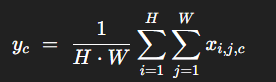


Shape: 12×12×128 → 128 (one value per channel).

Why it’s good here:

Parameter-efficient: no weights in GAP itself; it turns 12×12×128 (18,432 values) into just 128.

Regularization by design: encourages each channel to represent a class-relevant feature globally (less overfitting than Flatten).

Translation robustness: if the feature moves a bit in the image, the average still captures “how much” of that feature is present.

🔢 Parameter savings vs Flatten

With Flatten + Dense(128) you’d have ~2.36M weights (18,432×128) just for that layer.

With GAP, you go straight to a 128-length vector—massively fewer parameters in the head.

2) x = layers.BatchNormalization()(x)

What it does:

Normalizes the 128-dim vector to zero mean / unit variance per batch, then learns scale/shift (γ, β).

Shape: stays 128.

Training vs inference:

During training, uses batch statistics.

During inference, uses moving averages accumulated during training.

Why it helps:

Stabilizes activations → smoother, faster optimization.

Improves generalization: reduces internal covariate shift; often boosts recall by making the classifier head less sensitive to activation drift.

3) x = layers.Dropout(DROP)(x)

What it does:

Randomly zeros out a fraction (e.g., 40% if DROP=0.4) of the 128 activations only during training.

Shape: still 128.

Why we place it here:

After normalization, dropout discourages co-adaptation—the classifier can’t rely on any single unit.

This typically reduces overfitting and improves robustness, especially with small images (96×96) and modest data sizes.

4) outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

You’ve squeezed the image down to 128 useful numbers (features).

Now you need to decide: which of the 12 plant species is it?

This layer is like a voting booth:

Each of the 12 classes gets a score (called a logit).

Softmax turns those scores into probabilities that add up to 1.

👉 Example:
[0.01, 0.02, 0.85, 0.03, …] → means “85% confident it’s class 3”.

Shape (flow of data)

Input: 128 numbers (features).

Output: 12 numbers (one per class).

So the layer is just: 128 → 12.

5) model = Model(inputs, outputs, name="cnn_baseline_gap_bn")

What it does:

Connects your input tensor to the final outputs through the layers you defined, creating a complete Keras Model.

name is just a helpful tag (shows up in model.summary() and when saving).

Why Functional API:

Avoids the input_shape warning from Sequential.

More flexible if you later branch, add skip connections, or expose intermediate outputs (e.g., for feature extraction → SVM/XGBoost).

TL;DR intuition

GAP: “Summarize each learned feature map into one number.”

BatchNorm: “Keep those numbers stable across batches.”

Dropout: “Make the head robust—don’t lean on any one feature.”

Dense + Softmax: “Turn features into class probabilities.”
***********************
🔹 Why Dropout is used here

Prevents co-adaptation

Without dropout, some neurons in that 128-vector might “team up” and always fire together (e.g., feature A + feature B = class X).

That works great on training data, but if test images look slightly different, that fragile combo can fail.

Dropout forces each neuron to stand on its own — because any teammate could vanish in a given training step.

Simulates an ensemble

Each dropout mask (the pattern of dropped/kept neurons) effectively trains a slightly different “thinned” network.

At inference, dropout is turned off and activations are scaled, so you’re averaging over all those “subnetworks”.

That ensemble-like effect usually boosts generalization.

Balances overfitting risk

Your dataset (12 plant classes, 96×96 images) isn’t massive.

Even though GAP condensed it to 128 numbers, the final dense classifier could still overfit — especially if classes are uneven.

Dropout (e.g., 40%) is like saying: “Don’t trust this feature 100%; learn to spread the responsibility.”

🔹 Why not worry too much

At inference (test time), no neurons are dropped.
Dropout only applies during training. When you predict on new data, the full 128 vector is used, just slightly rescaled to account for training.

So you’re not actually “messing up” the 128 — you’re training it under a little controlled chaos so it’s more robust when you deploy it.

# **4. CNN Training**

In [16]:
# 4.1 Compile the model to use Adam optimiser at learning rate LR, compare entropy loss, and optimize accuracy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

#4.2 Use a callback to monitor the training
cb = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
'''
Callbacks are like little “helpers” that keep an eye on training and adjust things automatically.
  ReduceLROnPlateau: “Slow down when progress stalls.”
  EarlyStopping: “Stop if progress really stops.”
They’re often used in pairs. One gives the model more chances to fine-tune (lower LR), and the other ensures you don’t waste epochs if it’s truly done.
'''

'\nCallbacks are like little “helpers” that keep an eye on training and adjust things automatically.\n  ReduceLROnPlateau: “Slow down when progress stalls.”\n  EarlyStopping: “Stop if progress really stops.”\nThey’re often used in pairs. One gives the model more chances to fine-tune (lower LR), and the other ensures you don’t waste epochs if it’s truly done.\n'

In [17]:
# 4.3 Training
history = model.fit(
    train_ds_aug,                     # normalized + augmented
    validation_data=val_ds_norm,      # normalized only
    epochs=EPOCHS,
    callbacks=cb,
)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2575 - loss: 2.1390 - val_accuracy: 0.2781 - val_loss: 2.2841 - learning_rate: 0.0010
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4389 - loss: 1.6624 - val_accuracy: 0.2472 - val_loss: 2.1461 - learning_rate: 0.0010
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4794 - loss: 1.5418 - val_accuracy: 0.2767 - val_loss: 1.9190 - learning_rate: 0.0010
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5420 - loss: 1.3822 - val_accuracy: 0.4213 - val_loss: 1.6606 - learning_rate: 0.0010
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5544 - loss: 1.3190 - val_accuracy: 0.3919 - val_loss: 1.6524 - learning_rate: 0.0010
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5668 - loss: 1.3105 - val_accuracy: 0.3539 - val_loss: 1.8223 - learning_rate: 0.0010
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6002 - l

RESULTS

In [18]:
# 5.1 Evaluate (accuracy from Keras for convenience)
val_loss, val_acc = model.evaluate(val_ds_norm, verbose=0)

# 5.2 Robust metrics: compute from argmax and probabilities
# IMPORTANT: build y_true and y_prob from the SAME pass over val_ds_norm
y_true_batches, y_prob_batches = [], []
for x_batch, y_batch in val_ds_norm:                   # no shuffle in val_ds_norm
    y_true_batches.append(y_batch.numpy())             # one-hot
    y_prob_batches.append(model.predict(x_batch, verbose=0))  # softmax probs

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

y_true_1hot = np.concatenate(y_true_batches, axis=0)   # (N, C)
y_prob      = np.concatenate(y_prob_batches, axis=0)   # (N, C)

# integer labels and predicted classes
y_true = y_true_1hot.argmax(axis=1)
y_pred = y_prob.argmax(axis=1)

# Accuracy / Precision / Recall / F1
acc = accuracy_score(y_true, y_pred)
p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

# Multi-class ROC-AUC (one-vs-rest) from probabilities
auc_macro = roc_auc_score(y_true_1hot, y_prob, multi_class="ovr", average="macro")
auc_micro = roc_auc_score(y_true_1hot, y_prob, multi_class="ovr", average="micro")

print("\n=== Validation Metrics ===")
print(f"Keras   - val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
print(f"sklearn - acc     : {acc:.4f}")
print(f"sklearn - micro   : P={p_micro:.4f} R={r_micro:.4f} F1={f1_micro:.4f}")
print(f"sklearn - macro   : P={p_macro:.4f} R={r_macro:.4f} F1={f1_macro:.4f}")
print(f"ROC-AUC  - micro  : {auc_micro:.4f} | macro: {auc_macro:.4f}")



=== Validation Metrics ===
Keras   - val_loss: 1.0148 | val_acc: 0.6531
sklearn - acc     : 0.6531
sklearn - micro   : P=0.6531 R=0.6531 F1=0.6531
sklearn - macro   : P=0.6811 R=0.6318 F1=0.6161
ROC-AUC  - micro  : 0.9562 | macro: 0.9624


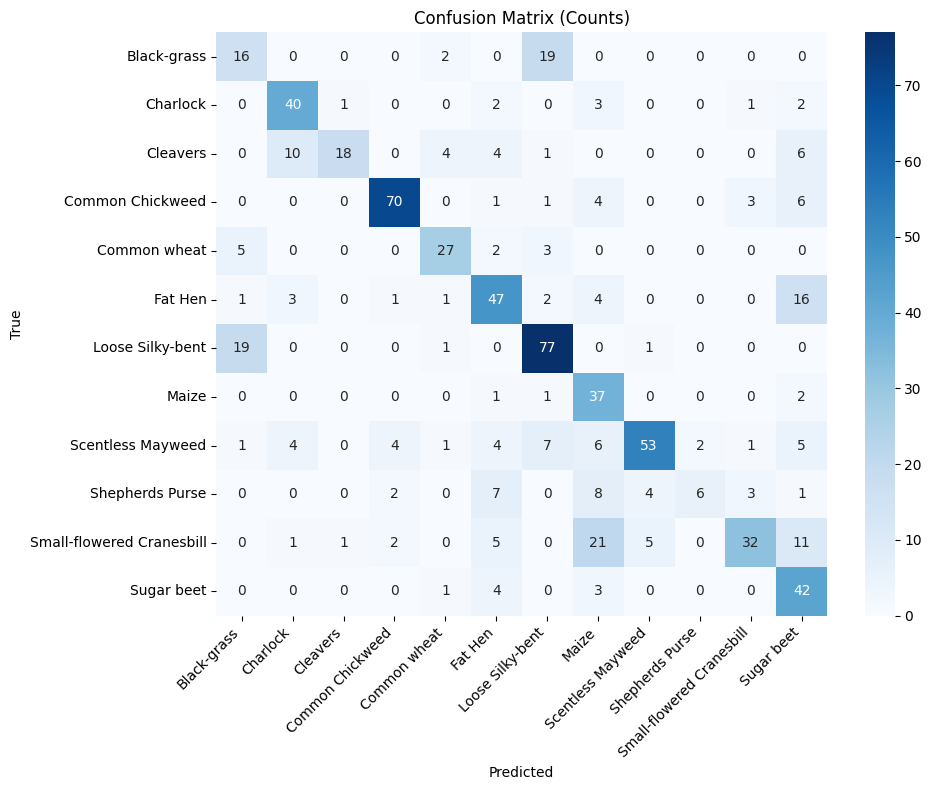

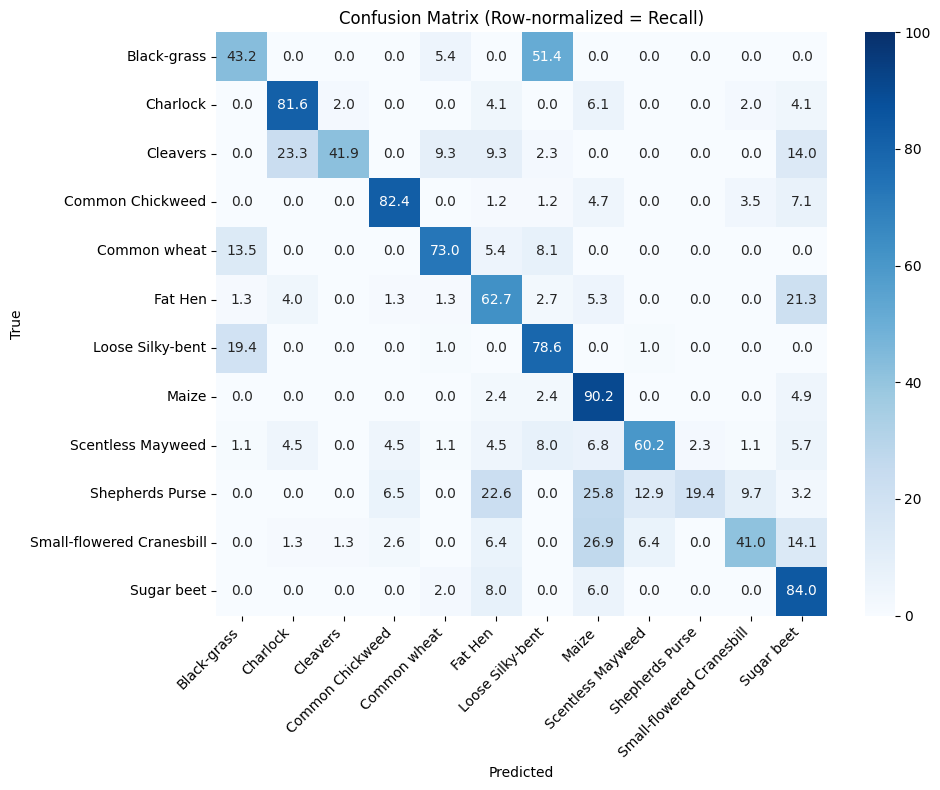

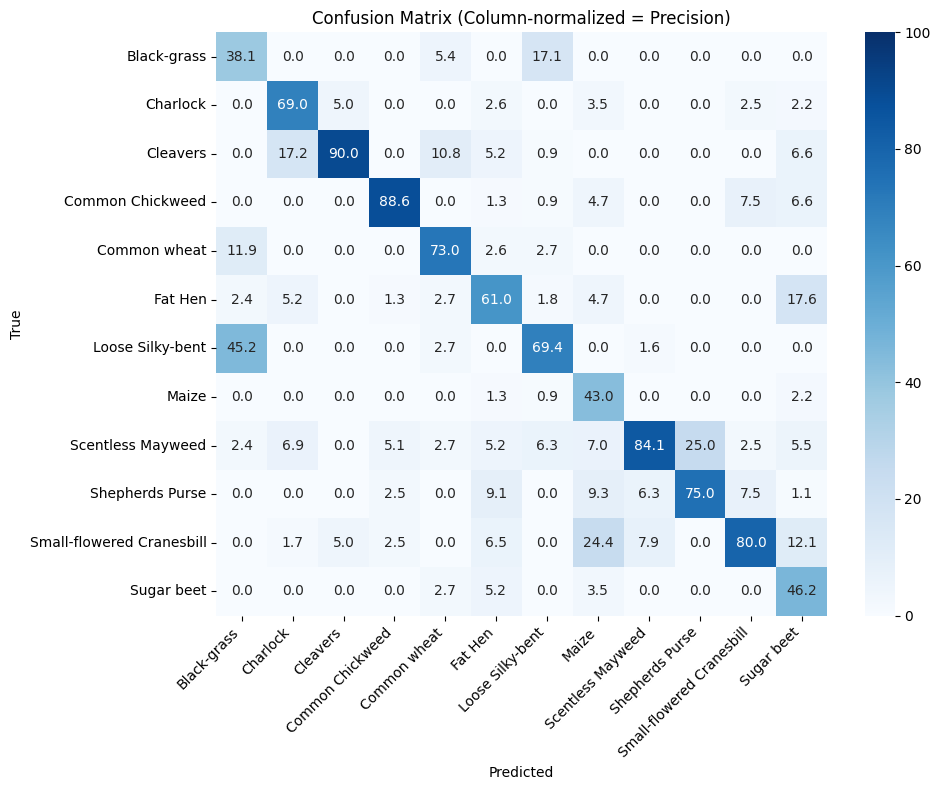

                           precision    recall  f1-score   support

              Black-grass     0.3810    0.4324    0.4051        37
                 Charlock     0.6897    0.8163    0.7477        49
                 Cleavers     0.9000    0.4186    0.5714        43
         Common Chickweed     0.8861    0.8235    0.8537        85
             Common wheat     0.7297    0.7297    0.7297        37
                  Fat Hen     0.6104    0.6267    0.6184        75
         Loose Silky-bent     0.6937    0.7857    0.7368        98
                    Maize     0.4302    0.9024    0.5827        41
        Scentless Mayweed     0.8413    0.6023    0.7020        88
          Shepherds Purse     0.7500    0.1935    0.3077        31
Small-flowered Cranesbill     0.8000    0.4103    0.5424        78
               Sugar beet     0.4615    0.8400    0.5957        50

                 accuracy                         0.6531       712
                macro avg     0.6811    0.6318    0.6161    

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use your existing class names
labels = train_ds.class_names
L = np.arange(len(labels))  # assumes y_true/y_pred are encoded as 0..K-1

def plot_cm(mat, title, labels, fmt=".2f", vmin=0, vmax=1):
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                vmin=vmin, vmax=vmax)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

# 1) Confusion Matrix (Counts)
cm = confusion_matrix(y_true, y_pred, labels=L)
plot_cm(cm, "Confusion Matrix (Counts)", labels, fmt="d", vmin=None, vmax=None)

# 2) Row-normalized (Recall per true class)
cm_row = confusion_matrix(y_true, y_pred, labels=L, normalize="true")
plot_cm(100*cm_row, "Confusion Matrix (Recall)", labels, fmt=".1f", vmin=0, vmax=100)

# 3) Column-normalized (Precision per predicted class)
cm_col = confusion_matrix(y_true, y_pred, labels=L, normalize="pred")
plot_cm(100*cm_col, "Confusion Matrix (Precision)", labels, fmt=".1f", vmin=0, vmax=100)

# Per-class metrics
print(classification_report(y_true, y_pred, target_names=train_ds.class_names, digits=4))


# **Feature Extraction**

# **5. SVM Training**


In [70]:
# 0) Imports + seeds
import numpy as np, tensorflow as tf, math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score)
import matplotlib.pyplot as plt
import random
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [71]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def get_gap_layer(m):
    # Walk layers in reverse until we find a GAP
    for layer in reversed(m.layers):
        if isinstance(layer, GlobalAveragePooling2D):
            return layer.name
    # Fallback: if no GAP, pick last layer before Dense/Dropout
    for layer in reversed(m.layers):
        if not ("dense" in layer.name.lower() or "dropout" in layer.name.lower()):
            return layer.name
    raise ValueError("No suitable GAP or pre-dense layer found!")

feat_layer_name = "conv2d_2"

feat_extractor = Model(inputs=model.input,
                       outputs=model.get_layer(feat_layer_name).output,
                       name="feat_extractor")

print("Using feature layer:", feat_layer_name, "-> shape:",
      feat_extractor.output_shape)


Using feature layer: global_average_pooling2d -> shape: (None, 128)


In [85]:
# 2) Make evaluation-ready datasets (no augmentation)
# Use the same normalization you use for model.evaluate. If your augmentation is inside the model, you don’t need to map anything here.

def ensure_eval_ds(ds):
    # If your pipeline already normalizes in ds, this is just cache/prefetch.
    return ds.cache().prefetch(AUTOTUNE)

train_eval = prep_eval(train_ds)   # labeled
val_eval   = prep_eval(val_ds)     # labeled


In [86]:
# 3) Extract features (batch-aligned) and labels
# Single-pass over each dataset to keep X/Y aligned and avoid any shuffle mismatches.
def extract_xy(ds, fnet):
    Xs, Ys = [], []
    for xb, yb in ds:
        fb = fnet.predict_on_batch(xb)  #Takes images and runs them straight through CNN w/o preprocessing or modifications. Returns the 128D vector which is a pure representation of the image as it went in. Mods are only done to train CNN, but here we just want feature rep of images.
        Xs.append(fb)
        Ys.append(yb.numpy())
    X = np.concatenate(Xs, axis=0)
    Y = np.concatenate(Ys, axis=0)

    if Y.ndim == 2:   # one-hot -> int labels
        Y = np.argmax(Y, axis=1)

    # Flatten features if needed
    X = X.reshape((X.shape[0], -1)) #Ensure Feature is 2D, incase Features were extracted earlier in the conv, could be 4D (N, H, W, D). Solve the issue by making X -> (N, HxWxD)
    return X, Y

X_tr, y_tr = extract_xy(train_eval, feat_extractor)
X_va, y_va = extract_xy(val_eval,   feat_extractor)

print("X_tr.shape:", X_tr.shape, "y_tr.shape:", y_tr.shape)
print("=========================")
print("X_va.shape:", X_va.shape, "y_va.shape:", y_va.shape)



X_tr.shape: (4038, 128) y_tr.shape: (4038,)
X_va.shape: (712, 128) y_va.shape: (712,)


In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced",
                probability=False, cache_size=1000))  # faster
])

# Coarser grid to start (9–12 combos)
param_grid = {
    "svc__C":     [0.1, 1, 10],
    "svc__gamma": [1e-3, 1e-2, 1e-1]  # you can add "scale" if you like
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)  # 3-fold is fine
grid = GridSearchCV(pipe, param_grid, scoring="f1_macro",
                    cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_tr, y_tr)

best = grid.best_params_
print(best, grid.best_score_)

# Final refit on ALL training data with probability=True (for ROC-AUC later)
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced",
                probability=True, cache_size=1000,
                C=best["svc__C"], gamma=best["svc__gamma"]))
])
svm_clf.fit(X_tr, y_tr)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'svc__C': 10, 'svc__gamma': 0.01} 0.8634637284717611


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=10, cache_size=1000, class_weight='balanced', gamma=0.01,
                     probability=True))])

In [88]:
#****************Test
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np

coarse_best = {"svc__C": 10, "svc__gamma": 0.01}  # from your run

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced",
                probability=False, cache_size=1000))
])

refine_grid = {
    "svc__C":     [3, 10, 30],
    "svc__gamma": [0.003, 0.01, 0.03],
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
refine = GridSearchCV(pipe, refine_grid, scoring="f1_macro",
                      cv=cv5, n_jobs=-1, verbose=1)
refine.fit(X_tr, y_tr)

best = refine.best_params_
print("Refined best:", best, " | cv5 macro-F1:", refine.best_score_)

# Final refit on all train, with probabilities enabled for ROC-AUC
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced",
                probability=True, cache_size=1000,
                C=best["svc__C"], gamma=best["svc__gamma"]))
]).fit(X_tr, y_tr)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Refined best: {'svc__C': 10, 'svc__gamma': 0.01}  | cv5 macro-F1: 0.8762344620741025


In [89]:
# 5) Evaluate on validation set (full suite)
y_pred = svm_clf.predict(X_va)
y_prob = svm_clf.predict_proba(X_va)

acc = accuracy_score(y_va, y_pred)
p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(y_va, y_pred, average="micro", zero_division=0)
p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_va, y_pred, average="macro", zero_division=0)
roc_micro = roc_auc_score(y_va, y_prob, multi_class="ovr", average="micro")
roc_macro = roc_auc_score(y_va, y_prob, multi_class="ovr", average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"Micro  P/R/F1: {p_micro:.4f} / {r_micro:.4f} / {f_micro:.4f}")
print(f"Macro  P/R/F1: {p_macro:.4f} / {r_macro:.4f} / {f_macro:.4f}")
print(f"ROC-AUC micro: {roc_micro:.4f} | macro: {roc_macro:.4f}")


Accuracy: 0.8708
Micro  P/R/F1: 0.8708 / 0.8708 / 0.8708
Macro  P/R/F1: 0.8647 / 0.8689 / 0.8634
ROC-AUC micro: 0.9933 | macro: 0.9915


In [77]:
# 0) Recover class_names (label→index mapping)
import os, numpy as np

def recover_class_names():
    # Prefer the dataset you trained with
    for ds_name in ["train_ds", "base_train"]:
        if ds_name in globals():
            ds = globals()[ds_name]
            if hasattr(ds, "class_names"):
                return list(ds.class_names)
    # Fallback: infer from directory (same alphabetical order TF uses)
    TRAIN_DIR = "/content/data/train_96pad"   # <-- adjust if needed
    return sorted([d for d in os.listdir(TRAIN_DIR)
                   if os.path.isdir(os.path.join(TRAIN_DIR, d))])

class_names = recover_class_names()
NUM_CLASSES = len(class_names)
print("Classes:", class_names, f"({NUM_CLASSES})")

# (Optional) sanity checks
assert NUM_CLASSES == (np.max(y_va)+1), "Label count mismatch—check TRAIN_DIR or dataset used."


Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'] (12)


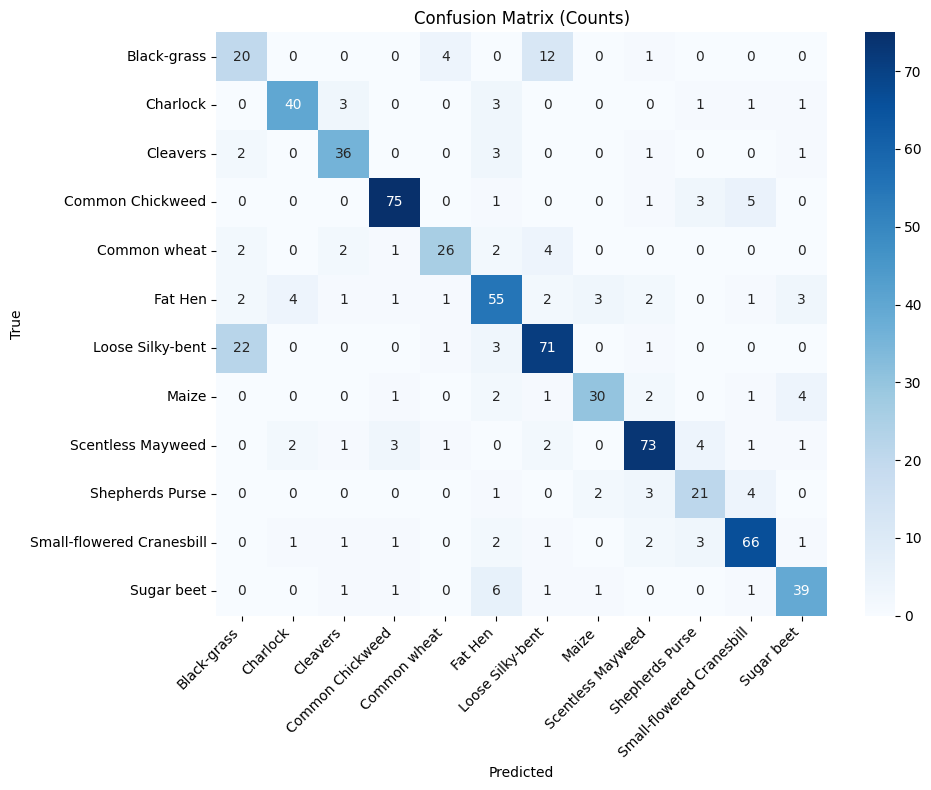

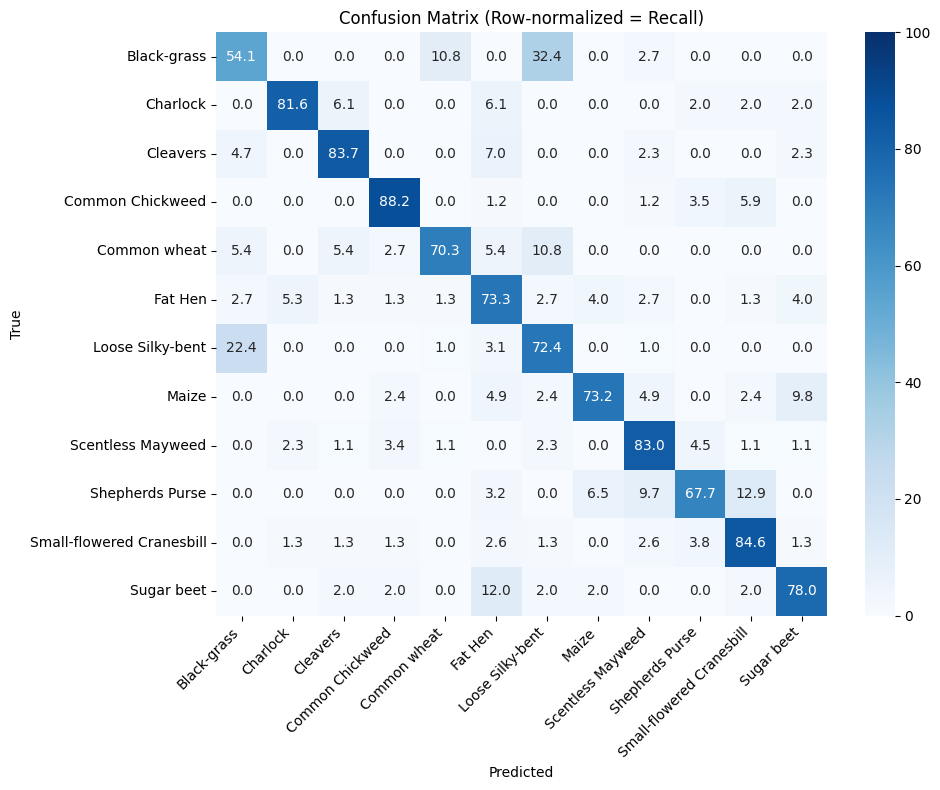

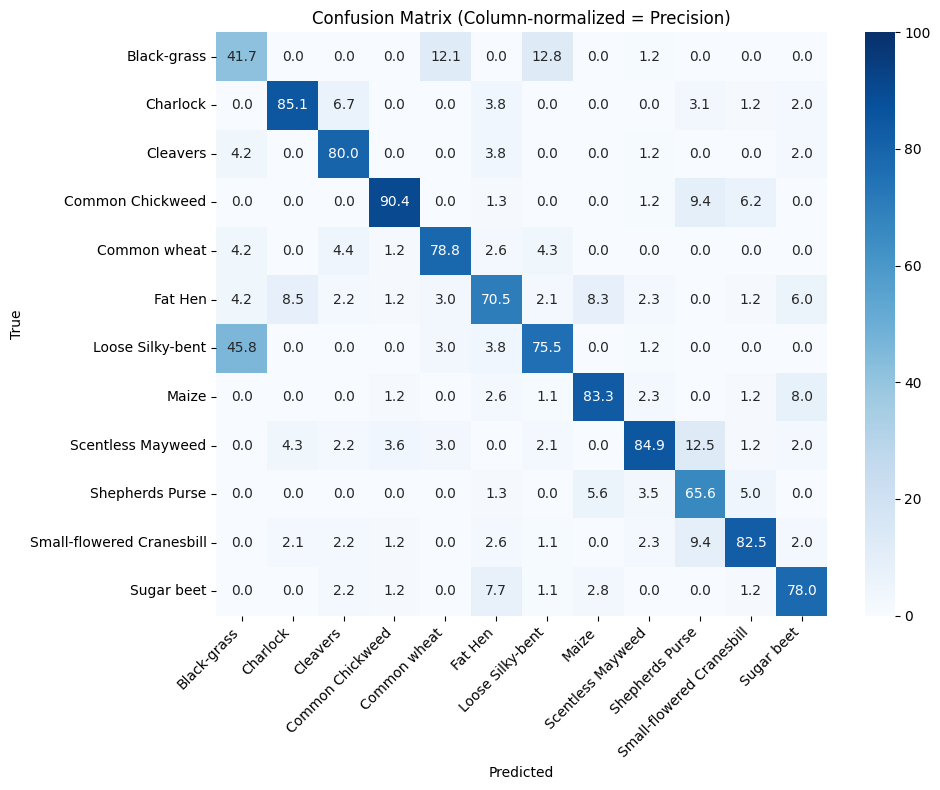

                           precision    recall  f1-score   support

              Black-grass     0.4167    0.5405    0.4706        37
                 Charlock     0.8511    0.8163    0.8333        49
                 Cleavers     0.8000    0.8372    0.8182        43
         Common Chickweed     0.9036    0.8824    0.8929        85
             Common wheat     0.7879    0.7027    0.7429        37
                  Fat Hen     0.7051    0.7333    0.7190        75
         Loose Silky-bent     0.7553    0.7245    0.7396        98
                    Maize     0.8333    0.7317    0.7792        41
        Scentless Mayweed     0.8488    0.8295    0.8391        88
          Shepherds Purse     0.6562    0.6774    0.6667        31
Small-flowered Cranesbill     0.8250    0.8462    0.8354        78
               Sugar beet     0.7800    0.7800    0.7800        50

                 accuracy                         0.7753       712
                macro avg     0.7636    0.7585    0.7597    

In [78]:
# 6) Confusion matrices (raw + row-normalized, red→green)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ground truth & predictions (keep as you already set them)
y_true = y_va
y_pred = y_pred

# Class labels
labels = (train_ds.class_names
          if 'train_ds' in globals() and hasattr(train_ds, 'class_names')
          else class_names)
L = np.arange(len(labels))

def plot_cm(mat, title, labels, fmt=".2f", vmin=0, vmax=1):
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                vmin=vmin, vmax=vmax)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

# 1) Counts (you already have this, kept here for completeness)
cm = confusion_matrix(y_true, y_pred, labels=L)
plot_cm(cm, "Confusion Matrix (Counts)", labels, fmt="d", vmin=None, vmax=None)

# 2) Row-normalized (recall per class)
cm_row = confusion_matrix(y_true, y_pred, labels=L, normalize="true")
plot_cm(100*cm_row, "Confusion Matrix (Row-normalized = Recall)", labels, fmt=".1f", vmin=0, vmax=100)

# 3) Column-normalized (precision per predicted class)
cm_col = confusion_matrix(y_true, y_pred, labels=L, normalize="pred")
plot_cm(100*cm_col, "Confusion Matrix (Column-normalized = Precision)", labels, fmt=".1f", vmin=0, vmax=100)

# If you prefer percentages:
# plot_cm(100*cm_row, "Confusion Matrix (Row-normalized, %)", labels, fmt=".1f", vmin=0, vmax=100)


from sklearn.metrics import classification_report
print(classification_report(y_va, y_pred, target_names=class_names, digits=4))


# **6. XGB Model**

In [90]:
!pip -q install xgboost


In [91]:
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix)
import matplotlib.pyplot as plt, seaborn as sns
SEED = 42

In [92]:
# 2) Prepare data (XGBoost prefers float32; no scaling needed)
X_tr_xgb = X_tr.astype(np.float32)
X_va_xgb = X_va.astype(np.float32)
NUM_CLASSES = len(class_names)

In [93]:
# 3) (Optional but recommended) Class-balanced sample we
hts

counts = np.bincount(y_tr, minlength=NUM_CLASSES)
class_w = {i: len(y_tr) / (NUM_CLASSES * max(counts[i], 1)) for i in range(NUM_CLASSES)}
w_tr = np.array([class_w[i] for i in y_tr], dtype=np.float32)

In [94]:
# 4) Define and fit XGBoost (GPU if available, else CPU)

import numpy as np
import xgboost as xgb

NUM_CLASSES = len(class_names)

# Ensure float32 for XGBoost
X_tr_xgb = X_tr.astype(np.float32)
X_va_xgb = X_va.astype(np.float32)

# If you don't already have weights, create simple class-balanced weights
try:
    w_tr
except NameError:
    counts = np.bincount(y_tr, minlength=NUM_CLASSES)
    class_w = {i: len(y_tr) / (NUM_CLASSES * max(counts[i], 1)) for i in range(NUM_CLASSES)}
    w_tr = np.array([class_w[i] for i in y_tr], dtype=np.float32)

# DMatrix containers
dtrain = xgb.DMatrix(X_tr_xgb, label=y_tr, weight=w_tr)
dvalid = xgb.DMatrix(X_va_xgb, label=y_va)

# Params (try GPU first; fall back to CPU hist if not available)
params = {
    "objective": "multi:softprob",
    "num_class": NUM_CLASSES,
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "eval_metric": "mlogloss",
    "tree_method": "gpu_hist",   # try GPU
    # "predictor": "gpu_predictor",  # optional
}

evals = [(dtrain, "train"), (dvalid, "valid")]
num_round = 2000

try:
    bst = xgb.train(params, dtrain, num_boost_round=num_round,
                    evals=evals, early_stopping_rounds=50, verbose_eval=False)
except Exception as e:
    print("GPU not available → falling back to CPU 'hist'. Reason:", e)
    params["tree_method"] = "hist"
    params.pop("predictor", None)
    bst = xgb.train(params, dtrain, num_boost_round=num_round,
                    evals=evals, early_stopping_rounds=50, verbose_eval=False)

# Predictions (probabilities and hard labels)
y_prob = bst.predict(dvalid)              # shape: (N_val, NUM_CLASSES)
y_pred = y_prob.argmax(axis=1)

# ...then compute your metrics & confusion matrices as before...


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [12:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [12:06:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


In [95]:
# 5) Evaluate (same suite you used for SVM)
import xgboost as xgb
def xgb_predict_auto():
    global y_pred, y_prob
    if 'bst' in globals():  # core API booster exists
        dvalid = xgb.DMatrix(X_va_xgb, label=y_va)
        y_prob = bst.predict(dvalid)
        y_pred = y_prob.argmax(axis=1)
        print("[OK] Used core API booster (bst).")
    elif 'xgb_clf' in globals():
        # Ensure it's fitted; sklearn wrapper exposes classes_ when fitted
        if not hasattr(xgb_clf, "classes_"):
            raise RuntimeError("xgb_clf is not fitted in this session. Call xgb_clf.fit(...) first.")
        y_prob = xgb_clf.predict_proba(X_va_xgb)
        y_pred = y_prob.argmax(axis=1)
        print("[OK] Used sklearn wrapper (xgb_clf).")
    else:
        raise RuntimeError("No XGBoost model found. Train either bst (core API) or xgb_clf (sklearn).")

xgb_predict_auto()


[OK] Used core API booster (bst).


In [96]:
import xgboost as xgb
# Make DMatrix for validation
dvalid = xgb.DMatrix(X_va_xgb, label=y_va)

# Probabilities and hard labels
y_prob = bst.predict(dvalid)           # shape: (N_val, NUM_CLASSES)
y_pred = y_prob.argmax(axis=1)

acc = accuracy_score(y_va, y_pred)
p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(y_va, y_pred, average="micro", zero_division=0)
p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_va, y_pred, average="macro", zero_division=0)
roc_micro = roc_auc_score(y_va, y_prob, multi_class="ovr", average="micro")
roc_macro = roc_auc_score(y_va, y_prob, multi_class="ovr", average="macro")

print(f"XGBoost — Acc: {acc:.4f} | F1 (micro/macro): {f_micro:.4f}/{f_macro:.4f} | ROC-AUC (micro/macro): {roc_micro:.4f}/{roc_macro:.4f}")


XGBoost — Acc: 0.8624 | F1 (micro/macro): 0.8624/0.8503 | ROC-AUC (micro/macro): 0.9916/0.9892


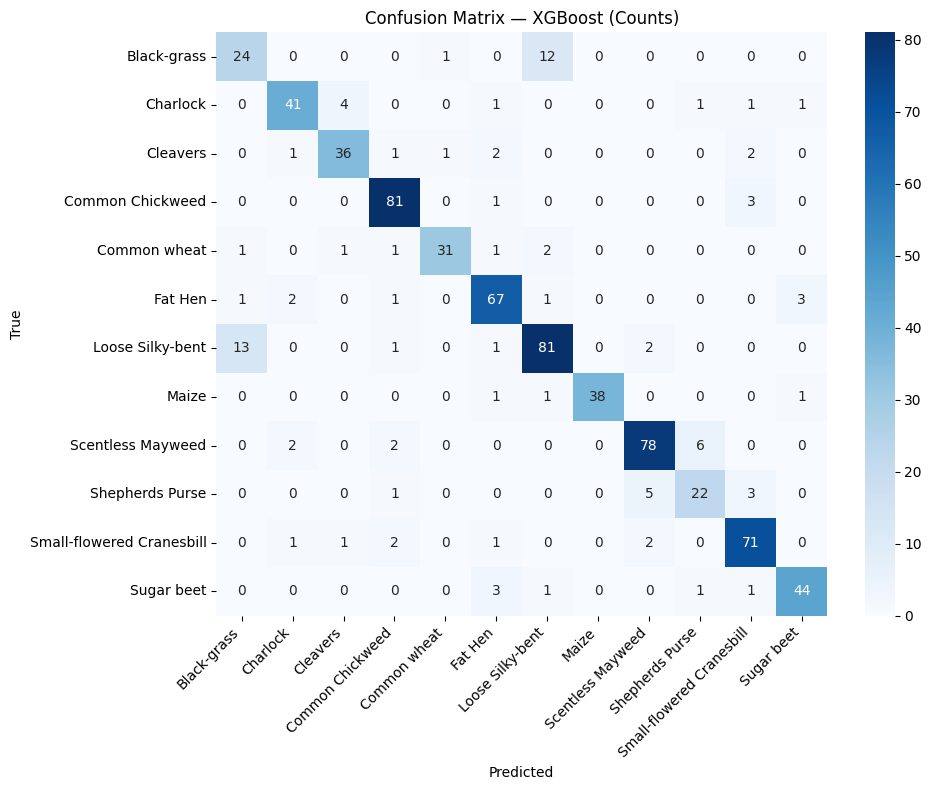

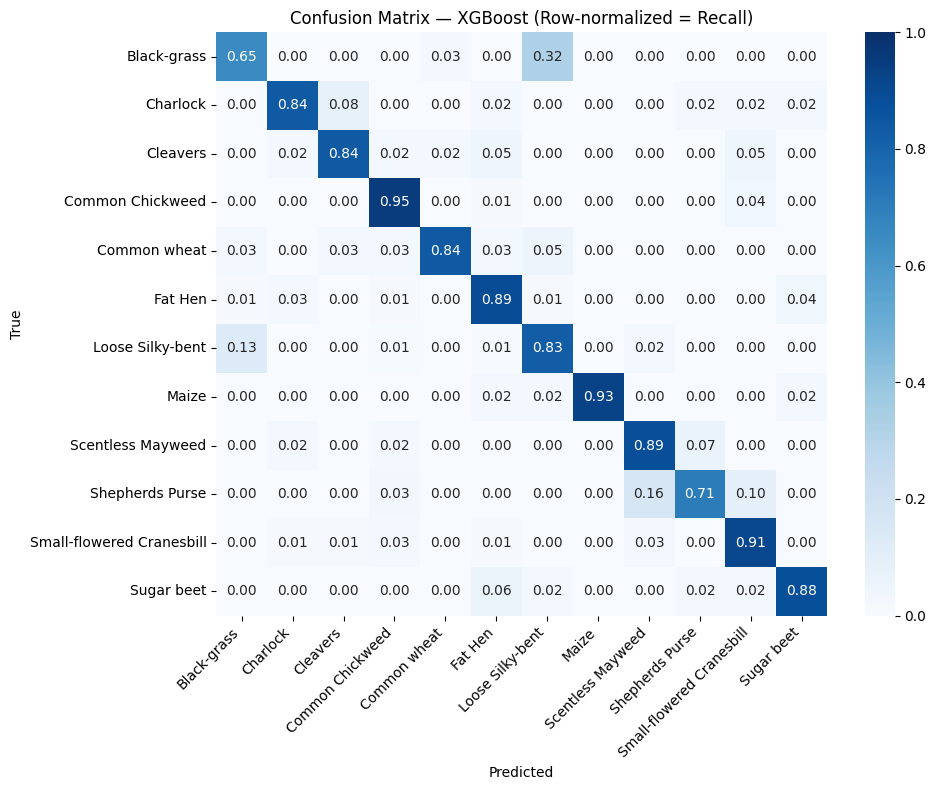

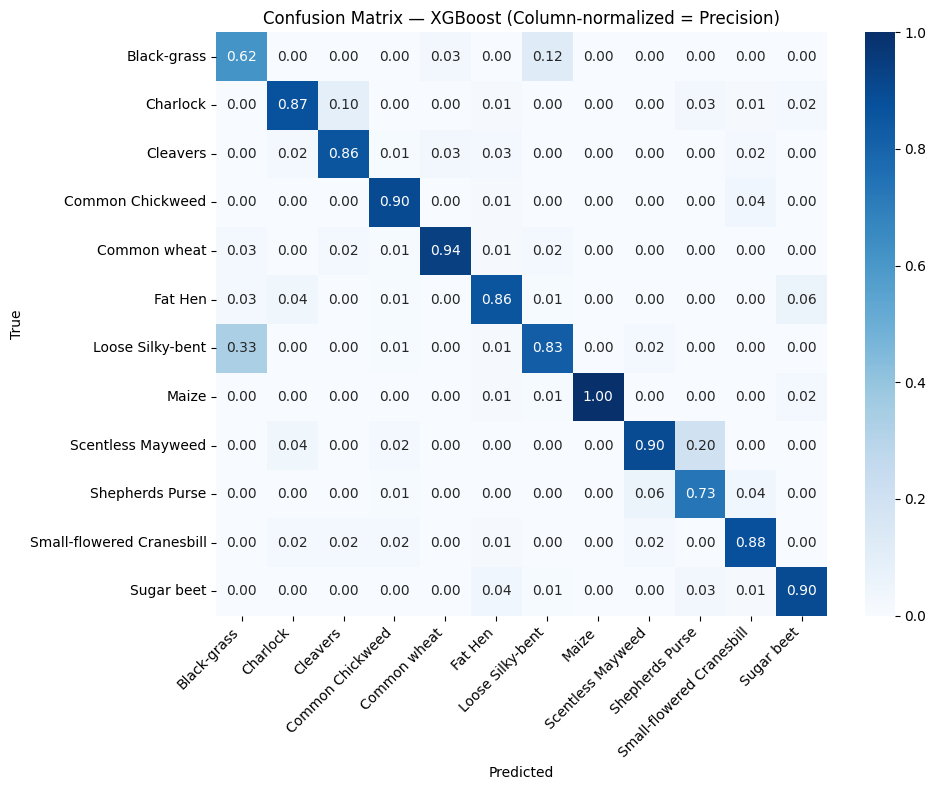

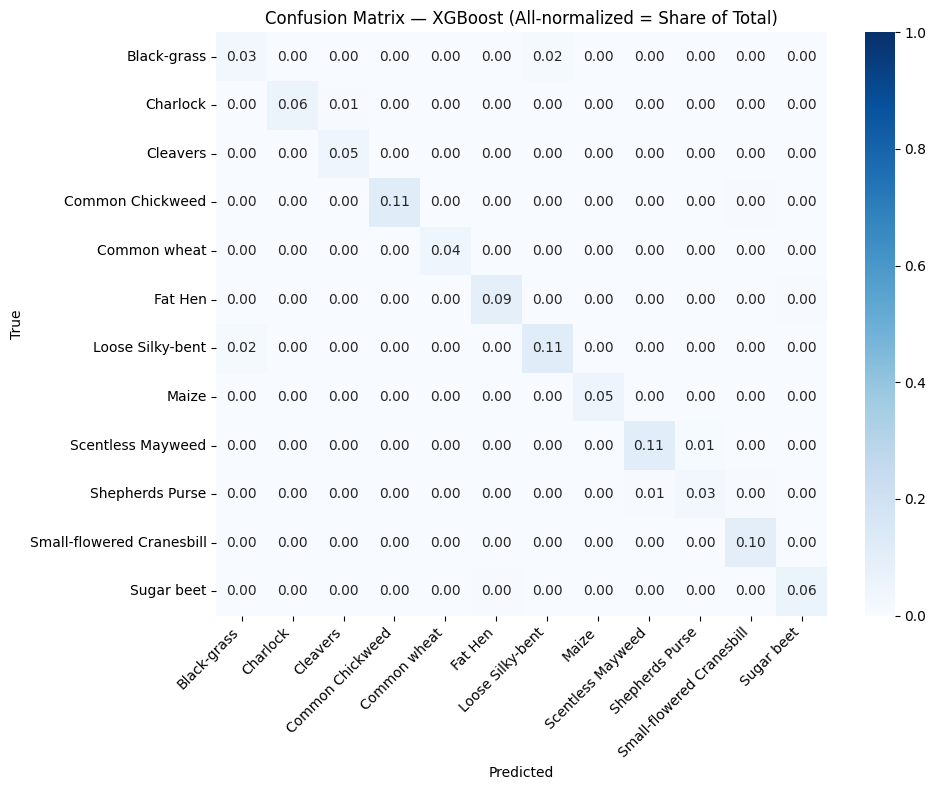

In [97]:
labels = class_names
L = np.arange(len(labels))

cm = confusion_matrix(y_va, y_pred, labels=L)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — XGBoost (Counts)")
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()

# Normalized views
cm_row = confusion_matrix(y_va, y_pred, labels=L, normalize="true")
cm_col = confusion_matrix(y_va, y_pred, labels=L, normalize="pred")
cm_all = confusion_matrix(y_va, y_pred, labels=L, normalize="all")

def plot_cm(mat, title, fmt=".2f", vmin=0, vmax=1):
    plt.figure(figsize=(10,8))
    sns.heatmap(mat, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels, vmin=vmin, vmax=vmax)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()

plot_cm(cm_row, "Confusion Matrix — XGBoost (Row-normalized = Recall)")
plot_cm(cm_col, "Confusion Matrix — XGBoost (Column-normalized = Precision)")
plot_cm(cm_all, "Confusion Matrix — XGBoost (All-normalized = Share of Total)")


# **7. Test Data**

=== Extracting features from test dataset ===


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_8
Received: inputs=('Tensor(shape=(32, 96, 96, 3))',)
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_8
Received: inputs=('Tensor(shape=(None, 96, 96, 3))',)
  warnings.warn(msg)


Test features extracted: (794, 128)

=== FEATURE ANALYSIS DIAGNOSTIC ===
Feature Statistics Comparison:
Training features   - Mean: 0.082404, Std: 0.118206
Validation features - Mean: 0.082098, Std: 0.117893
Test features       - Mean: 0.080572, Std: 0.116680

Feature Variance:
Training avg variance per feature: 0.002049
Test avg variance per feature:     0.001842
Variance ratio (test/train):       0.899140

Training Feature Diversity:
  Features with near-zero variance: 49/128
  Features with tiny range: 45/128
  Min/Max feature values: 0.000000 / 0.863976

Validation Feature Diversity:
  Features with near-zero variance: 48/128
  Features with tiny range: 48/128
  Min/Max feature values: 0.000000 / 0.866069

Test Feature Diversity:
  Features with near-zero variance: 49/128
  Features with tiny range: 48/128
  Min/Max feature values: 0.000000 / 0.805383


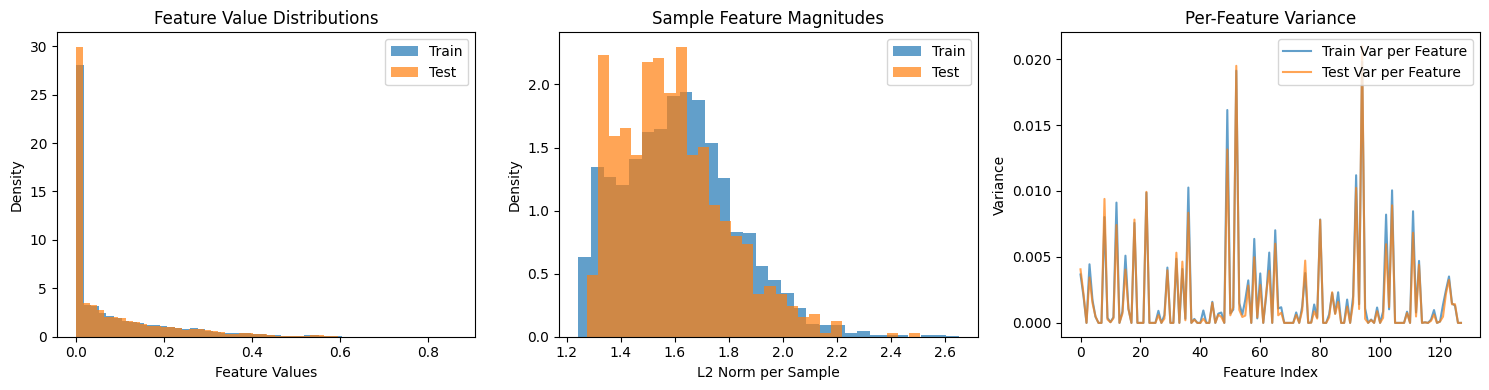


=== FEATURE SIMILARITY ANALYSIS ===
Test sample similarities - Mean: 0.9126, Std: 0.0728
Test samples with >0.95 similarity: 3682/9900 (37.2%)
Train sample similarities - Mean: 0.9155, Std: 0.0660
Train samples with >0.95 similarity: 3764/9900 (38.0%)

=== TESTING DIFFERENT FEATURE LAYERS ===
Available layers in your CNN:

Testing BatchNorm features...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_8
Received: inputs=('Tensor(shape=(32, 96, 96, 3))',)
  warnings.warn(msg)


BatchNorm features shape: (32, 128)
BatchNorm features - Mean: -0.014515, Std: 0.673047

=== CONCLUSION ===
If test features have:
  • Much higher similarity than training features → Feature collapse
  • Very different mean/std than training → Distribution shift
  • Many near-zero variance features → Information loss
Then the 128D dropout features are not discriminative enough for SVM/XGBoost!


In [98]:
 #**7. Test Dataset Evaluation**

# 7.1 Extract features from test dataset using trained CNN
print("=== Extracting features from test dataset ===")

# Test dataset is unlabeled, so we extract features only
X_test_batches = []
for x_batch in test_ds_norm:  # test_ds_norm from your existing pipeline
    fb = feat_extractor.predict_on_batch(x_batch)
    X_test_batches.append(fb)

X_test = np.concatenate(X_test_batches, axis=0)
X_test = X_test.reshape((X_test.shape[0], -1))  # Flatten if needed
print(f"Test features extracted: {X_test.shape}")

# Add this diagnostic code after feature extraction in Section 7

print("\n=== FEATURE ANALYSIS DIAGNOSTIC ===")

# 1. Compare feature distributions
print("Feature Statistics Comparison:")
print(f"Training features   - Mean: {X_tr.mean():.6f}, Std: {X_tr.std():.6f}")
print(f"Validation features - Mean: {X_va.mean():.6f}, Std: {X_va.std():.6f}")
print(f"Test features       - Mean: {X_test.mean():.6f}, Std: {X_test.std():.6f}")

# 2. Check feature diversity/variance
train_feature_var = np.var(X_tr, axis=0)
test_feature_var = np.var(X_test, axis=0)

print(f"\nFeature Variance:")
print(f"Training avg variance per feature: {train_feature_var.mean():.6f}")
print(f"Test avg variance per feature:     {test_feature_var.mean():.6f}")
print(f"Variance ratio (test/train):       {test_feature_var.mean()/train_feature_var.mean():.6f}")

# 3. Check for feature collapse (all similar values)
def check_feature_diversity(features, name):
    # Check how many features have very low variance (collapsed)
    low_var_threshold = 1e-6
    low_var_features = np.sum(np.var(features, axis=0) < low_var_threshold)

    # Check range of values
    feature_ranges = np.max(features, axis=0) - np.min(features, axis=0)
    small_range_features = np.sum(feature_ranges < 1e-4)

    print(f"\n{name} Feature Diversity:")
    print(f"  Features with near-zero variance: {low_var_features}/{features.shape[1]}")
    print(f"  Features with tiny range: {small_range_features}/{features.shape[1]}")
    print(f"  Min/Max feature values: {features.min():.6f} / {features.max():.6f}")

    return low_var_features, small_range_features

check_feature_diversity(X_tr, "Training")
check_feature_diversity(X_va, "Validation")
check_feature_diversity(X_test, "Test")

# 4. Visualize feature distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(X_tr.flatten(), bins=50, alpha=0.7, label='Train', density=True)
plt.hist(X_test.flatten(), bins=50, alpha=0.7, label='Test', density=True)
plt.xlabel('Feature Values')
plt.ylabel('Density')
plt.title('Feature Value Distributions')
plt.legend()

plt.subplot(1, 3, 2)
train_sample_norms = np.linalg.norm(X_tr, axis=1)
test_sample_norms = np.linalg.norm(X_test, axis=1)
plt.hist(train_sample_norms, bins=30, alpha=0.7, label='Train', density=True)
plt.hist(test_sample_norms, bins=30, alpha=0.7, label='Test', density=True)
plt.xlabel('L2 Norm per Sample')
plt.ylabel('Density')
plt.title('Sample Feature Magnitudes')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.var(X_tr, axis=0), label='Train Var per Feature', alpha=0.7)
plt.plot(np.var(X_test, axis=0), label='Test Var per Feature', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.title('Per-Feature Variance')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Check if test features are collapsing to similar values
print(f"\n=== FEATURE SIMILARITY ANALYSIS ===")
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise similarities within test set (sample 100 to avoid memory issues)
if len(X_test) > 100:
    test_sample_idx = np.random.choice(len(X_test), 100, replace=False)
    test_subset = X_test[test_sample_idx]
else:
    test_subset = X_test

test_similarities = cosine_similarity(test_subset)
# Remove diagonal (self-similarity = 1)
mask = ~np.eye(test_similarities.shape[0], dtype=bool)
test_sim_values = test_similarities[mask]

print(f"Test sample similarities - Mean: {test_sim_values.mean():.4f}, Std: {test_sim_values.std():.4f}")
print(f"Test samples with >0.95 similarity: {np.sum(test_sim_values > 0.95)}/{len(test_sim_values)} ({100*np.mean(test_sim_values > 0.95):.1f}%)")

# 6. Compare to training similarities
if len(X_tr) > 100:
    train_sample_idx = np.random.choice(len(X_tr), 100, replace=False)
    train_subset = X_tr[train_sample_idx]
else:
    train_subset = X_tr

train_similarities = cosine_similarity(train_subset)
train_sim_values = train_similarities[~np.eye(train_similarities.shape[0], dtype=bool)]

print(f"Train sample similarities - Mean: {train_sim_values.mean():.4f}, Std: {train_sim_values.std():.4f}")
print(f"Train samples with >0.95 similarity: {np.sum(train_sim_values > 0.95)}/{len(train_sim_values)} ({100*np.mean(train_sim_values > 0.95):.1f}%)")

# 7. Test with different feature extraction layers
print(f"\n=== TESTING DIFFERENT FEATURE LAYERS ===")
print("Available layers in your CNN:")
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'output_shape') and len(layer.output_shape) >= 2:
        print(f"  Layer {i}: {layer.name} -> {layer.output_shape}")

# Test batch normalization layer if available
try:
    bn_layer = model.get_layer("batch_normalization")
    print(f"\nTesting BatchNorm features...")
    bn_extractor = Model(inputs=model.input, outputs=bn_layer.output)

    # Extract features from first batch of test data
    for x_batch in test_ds_norm.take(1):
        test_bn_features = bn_extractor.predict_on_batch(x_batch)
        print(f"BatchNorm features shape: {test_bn_features.shape}")
        print(f"BatchNorm features - Mean: {test_bn_features.mean():.6f}, Std: {test_bn_features.std():.6f}")
        break

except:
    print("No batch normalization layer found")

print(f"\n=== CONCLUSION ===")
print("If test features have:")
print("  • Much higher similarity than training features → Feature collapse")
print("  • Very different mean/std than training → Distribution shift")
print("  • Many near-zero variance features → Information loss")
print("Then the 128D dropout features are not discriminative enough for SVM/XGBoost!")


=== CNN (Softmax Head) Test Predictions ===
CNN test predictions shape: (794,)
CNN prediction distribution:
  Black-grass: 13 samples (1.6%)
  Charlock: 73 samples (9.2%)
  Cleavers: 27 samples (3.4%)
  Common Chickweed: 95 samples (12.0%)
  Common wheat: 40 samples (5.0%)
  Fat Hen: 66 samples (8.3%)
  Loose Silky-bent: 147 samples (18.5%)
  Maize: 69 samples (8.7%)
  Scentless Mayweed: 36 samples (4.5%)
  Shepherds Purse: 14 samples (1.8%)
  Small-flowered Cranesbill: 43 samples (5.4%)
  Sugar beet: 171 samples (21.5%)

=== SVM Test Predictions ===
SVM test predictions shape: (794,)
SVM prediction distribution:
  Black-grass: 41 samples (5.2%)
  Charlock: 61 samples (7.7%)
  Cleavers: 51 samples (6.4%)
  Common Chickweed: 102 samples (12.8%)
  Common wheat: 33 samples (4.2%)
  Fat Hen: 69 samples (8.7%)
  Loose Silky-bent: 113 samples (14.2%)
  Maize: 37 samples (4.7%)
  Scentless Mayweed: 75 samples (9.4%)
  Shepherds Purse: 53 samples (6.7%)
  Small-flowered Cranesbill: 87 samples

/tmp/ipython-input-2843952223.py:248: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(
/tmp/ipython-input-2843952223.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")


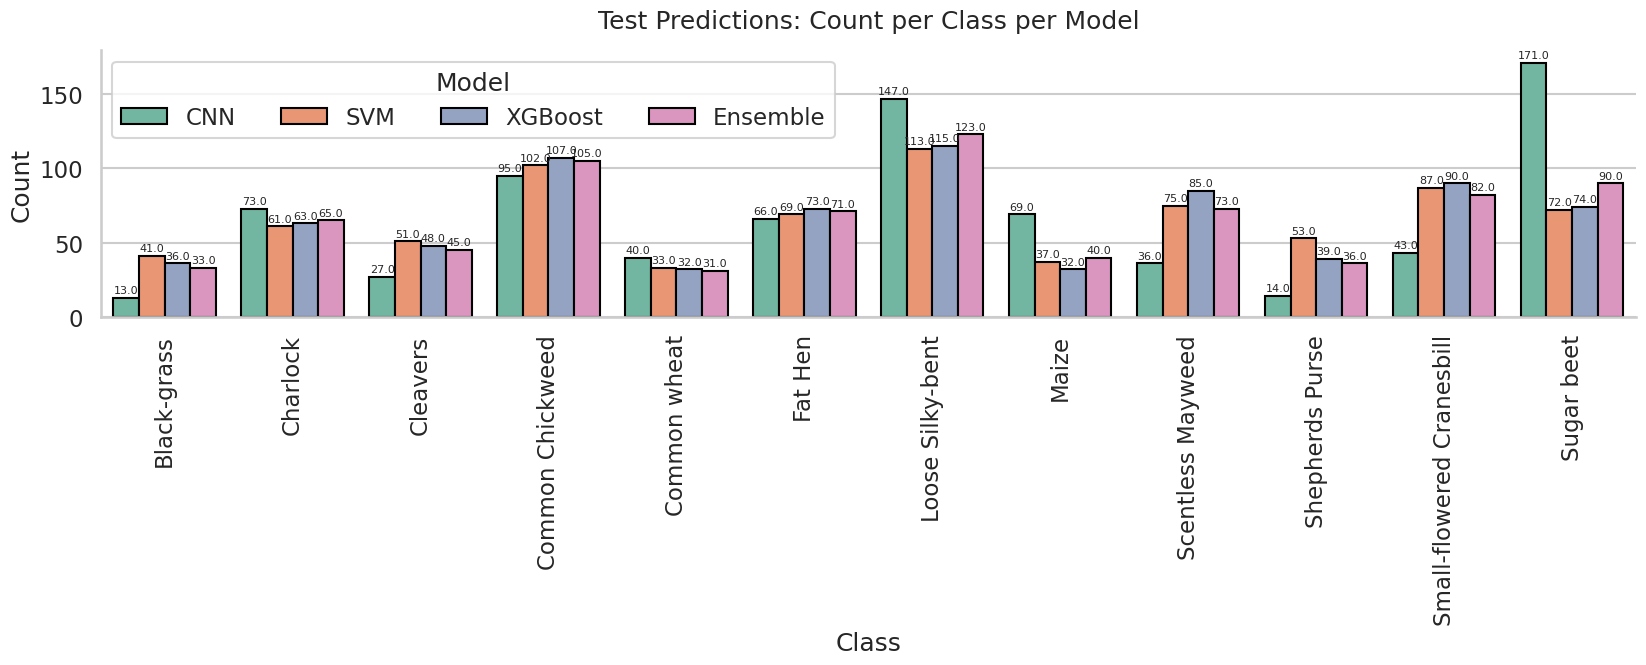

/tmp/ipython-input-2843952223.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


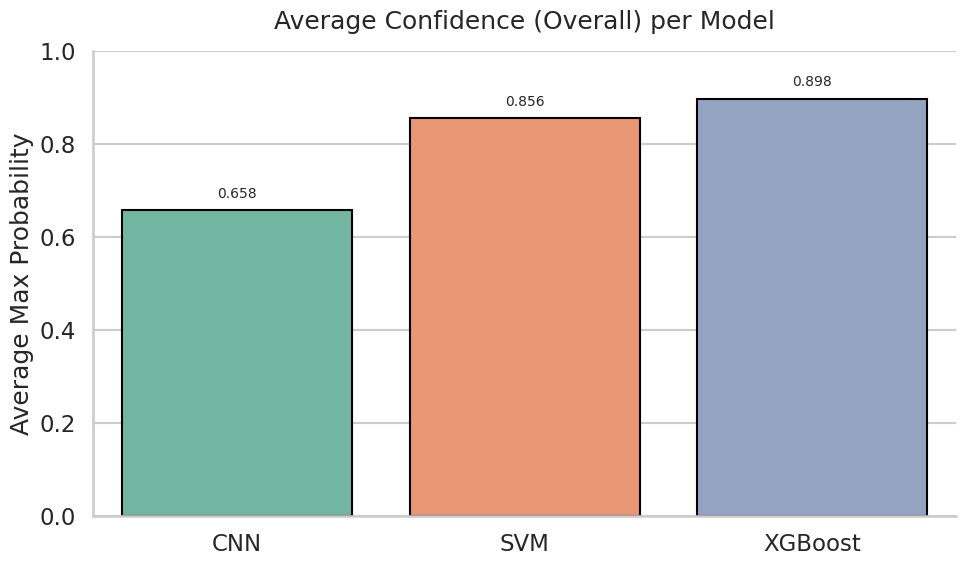

/tmp/ipython-input-2843952223.py:283: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax3 = sns.barplot(


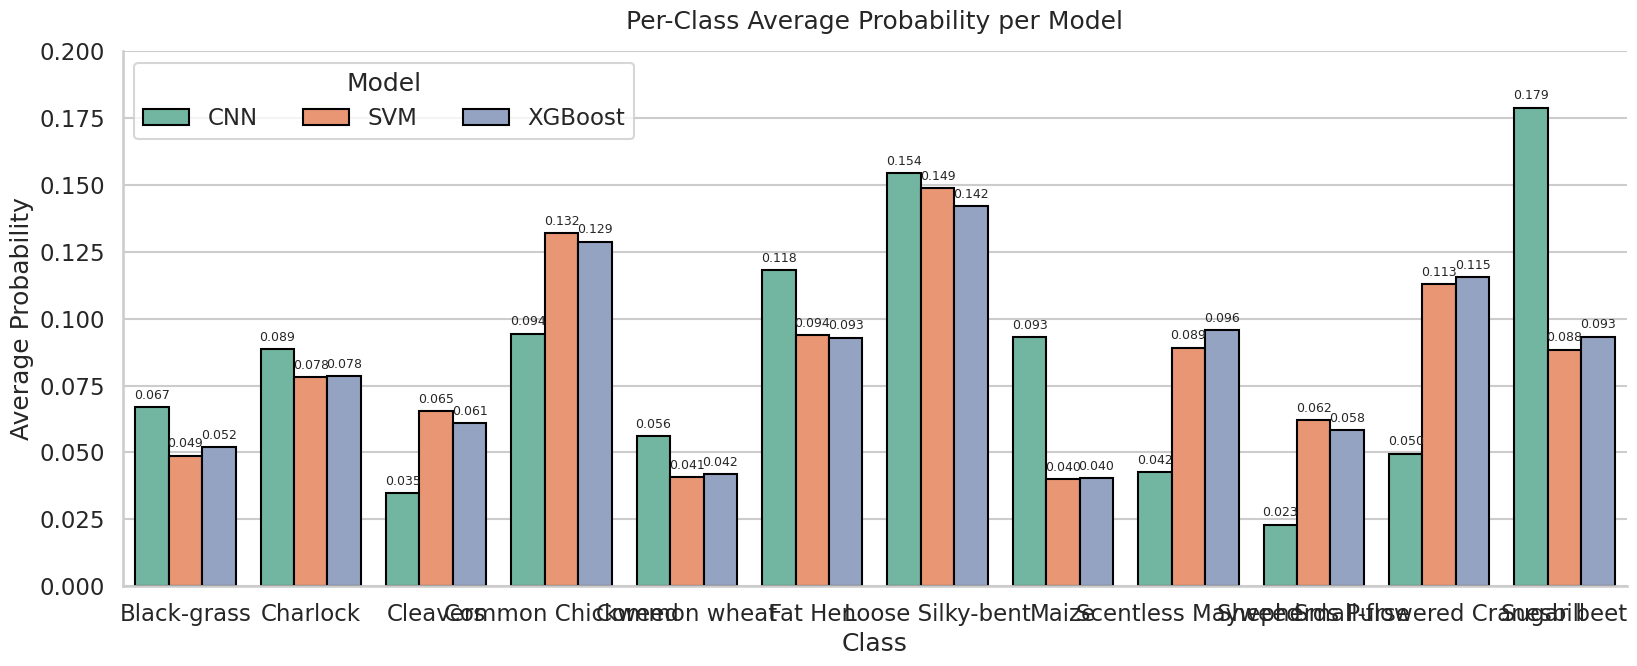

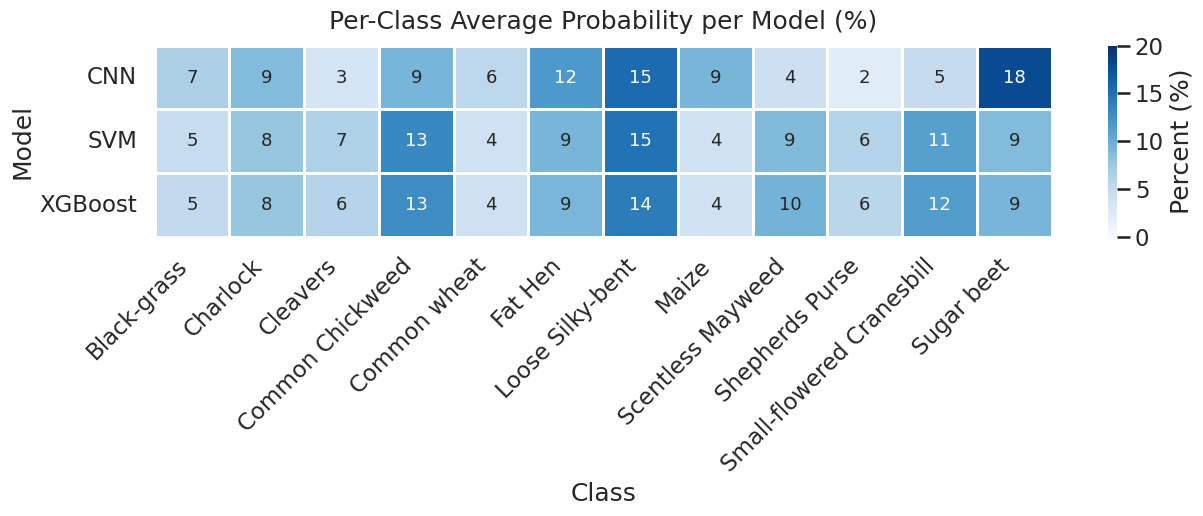

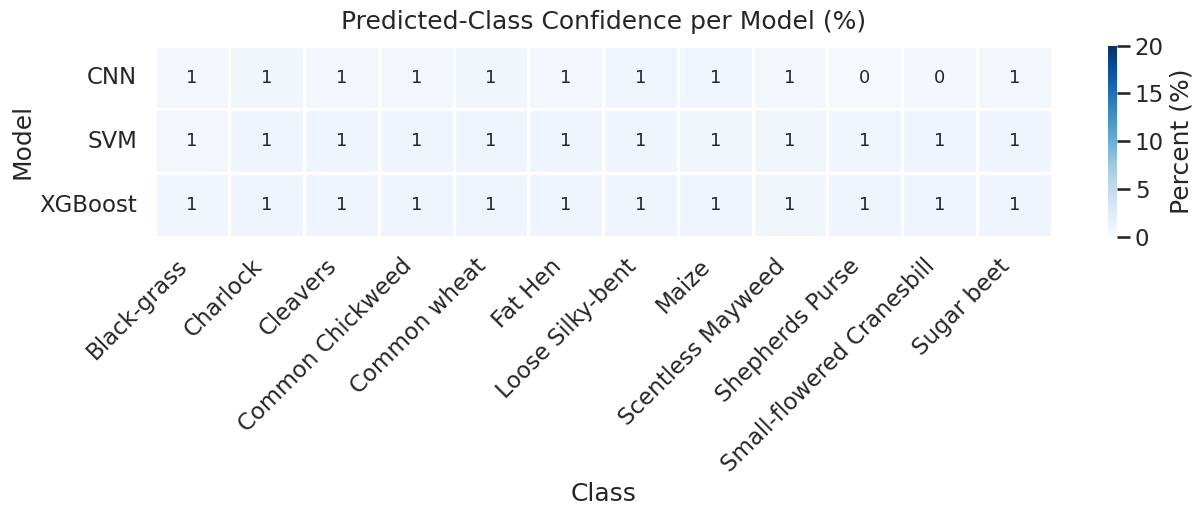

In [111]:
# 7.2 CNN Softmax Predictions on Test Set
print("\n=== CNN (Softmax Head) Test Predictions ===")

# Get probabilities and predictions directly from the full CNN model
test_prob_cnn_batches = []
for x_batch in test_ds_norm:
    prob_batch = model.predict_on_batch(x_batch)
    test_prob_cnn_batches.append(prob_batch)

test_prob_cnn = np.concatenate(test_prob_cnn_batches, axis=0)
test_pred_cnn = test_prob_cnn.argmax(axis=1)

print(f"CNN test predictions shape: {test_pred_cnn.shape}")
print(f"CNN prediction distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(test_pred_cnn == i)
    print(f"  {class_name}: {count} samples ({100*count/len(test_pred_cnn):.1f}%)")

# 7.3 SVM Predictions on Test Set
print("\n=== SVM Test Predictions ===")

test_pred_svm = svm_clf.predict(X_test)
test_prob_svm = svm_clf.predict_proba(X_test)

print(f"SVM test predictions shape: {test_pred_svm.shape}")
print(f"SVM prediction distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(test_pred_svm == i)
    print(f"  {class_name}: {count} samples ({100*count/len(test_pred_svm):.1f}%)")

# 7.4 XGBoost Predictions on Test Set
print("\n=== XGBoost Test Predictions ===")

# Convert to float32 for XGBoost
X_test_xgb = X_test.astype(np.float32)
dtest = xgb.DMatrix(X_test_xgb)

test_prob_xgb = bst.predict(dtest)
test_pred_xgb = test_prob_xgb.argmax(axis=1)

print(f"XGBoost test predictions shape: {test_pred_xgb.shape}")
print(f"XGBoost prediction distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(test_pred_xgb == i)
    print(f"  {class_name}: {count} samples ({100*count/len(test_pred_xgb):.1f}%)")

# 7.5 Agreement Analysis Between Models
print("\n=== Model Agreement Analysis ===")

# Pairwise agreement
cnn_svm_agree = np.sum(test_pred_cnn == test_pred_svm) / len(test_pred_cnn)
cnn_xgb_agree = np.sum(test_pred_cnn == test_pred_xgb) / len(test_pred_cnn)
svm_xgb_agree = np.sum(test_pred_svm == test_pred_xgb) / len(test_pred_svm)

print(f"CNN ↔ SVM agreement: {100*cnn_svm_agree:.1f}%")
print(f"CNN ↔ XGBoost agreement: {100*cnn_xgb_agree:.1f}%")
print(f"SVM ↔ XGBoost agreement: {100*svm_xgb_agree:.1f}%")

# All three agree
all_agree = np.sum((test_pred_cnn == test_pred_svm) &
                   (test_pred_svm == test_pred_xgb)) / len(test_pred_cnn)
print(f"All three models agree: {100*all_agree:.1f}%")

# 7.6 Confidence Analysis
print("\n=== Confidence Analysis ===")

# Average confidence per model (max probability)
conf_cnn = np.max(test_prob_cnn, axis=1)
conf_svm = np.max(test_prob_svm, axis=1)
conf_xgb = np.max(test_prob_xgb, axis=1)

print(f"Average confidence scores:")
print(f"  CNN: {np.mean(conf_cnn):.3f} ± {np.std(conf_cnn):.3f}")
print(f"  SVM: {np.mean(conf_svm):.3f} ± {np.std(conf_svm):.3f}")
print(f"  XGBoost: {np.mean(conf_xgb):.3f} ± {np.std(conf_xgb):.3f}")

# 7.7 High Confidence vs Low Confidence Samples
print("\n=== High/Low Confidence Sample Analysis ===")

# Define thresholds
high_conf_thresh = 0.8
low_conf_thresh = 0.5

for model_name, confidences, predictions in [
    ("CNN", conf_cnn, test_pred_cnn),
    ("SVM", conf_svm, test_pred_svm),
    ("XGBoost", conf_xgb, test_pred_xgb)
]:
    high_conf_mask = confidences > high_conf_thresh
    low_conf_mask = confidences < low_conf_thresh

    print(f"\n{model_name}:")
    print(f"  High confidence (>{high_conf_thresh}): {np.sum(high_conf_mask)} samples ({100*np.mean(high_conf_mask):.1f}%)")
    print(f"  Low confidence (<{low_conf_thresh}): {np.sum(low_conf_mask)} samples ({100*np.mean(low_conf_mask):.1f}%)")

    if np.sum(high_conf_mask) > 0:
        high_conf_classes = predictions[high_conf_mask]
        most_confident_class = np.bincount(high_conf_classes).argmax()
        print(f"  Most confident about: {class_names[most_confident_class]}")

# 7.8 Ensemble Prediction (Simple Majority Vote)
print("\n=== Ensemble Prediction (Majority Vote) ===")

# Stack predictions for easy comparison
pred_stack = np.column_stack([test_pred_cnn, test_pred_svm, test_pred_xgb])

# Majority vote for each sample
ensemble_pred = []
for i in range(len(pred_stack)):
    votes = pred_stack[i]
    # Count votes for each class
    vote_counts = np.bincount(votes, minlength=NUM_CLASSES)
    # If tie, use CNN prediction as tiebreaker
    if np.sum(vote_counts == np.max(vote_counts)) > 1:
        ensemble_pred.append(test_pred_cnn[i])
    else:
        ensemble_pred.append(np.argmax(vote_counts))

ensemble_pred = np.array(ensemble_pred)

print(f"Ensemble prediction distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(ensemble_pred == i)
    print(f"  {class_name}: {count} samples ({100*count/len(ensemble_pred):.1f}%)")

# 7.9 Summary Results Table
print("\n=== TEST SET RESULTS SUMMARY ===")
print("="*60)
print(f"{'Model':<15} {'Total Samples':<15} {'Avg Confidence':<15} {'Top Predicted Class':<20}")
print("-"*60)

for model_name, confidences, predictions in [
    ("CNN", conf_cnn, test_pred_cnn),
    ("SVM", conf_svm, test_pred_svm),
    ("XGBoost", conf_xgb, test_pred_xgb)
]:
    most_pred_class_idx = np.bincount(predictions).argmax()
    most_pred_class = class_names[most_pred_class_idx]
    most_pred_count = np.sum(predictions == most_pred_class_idx)

    print(f"{model_name:<15} {len(predictions):<15} {np.mean(confidences):<15.3f} {most_pred_class} ({most_pred_count})")

print(f"{'Ensemble':<15} {len(ensemble_pred):<15} {'N/A':<15} {class_names[np.bincount(ensemble_pred).argmax()]} ({np.max(np.bincount(ensemble_pred))})")
print("="*60)

# 7.10 Save Results (Optional)
print("\n=== Saving Test Results ===")

# Create results dictionary
test_results = {
    'cnn_predictions': test_pred_cnn,
    'svm_predictions': test_pred_svm,
    'xgb_predictions': test_pred_xgb,
    'ensemble_predictions': ensemble_pred,
    'cnn_probabilities': test_prob_cnn,
    'svm_probabilities': test_prob_svm,
    'xgb_probabilities': test_prob_xgb,
    'class_names': class_names,
    'agreement_stats': {
        'cnn_svm_agreement': cnn_svm_agree,
        'cnn_xgb_agreement': cnn_xgb_agree,
        'svm_xgb_agreement': svm_xgb_agree,
        'all_models_agreement': all_agree
    }
}

# Save to numpy archive
np.savez('test_predictions.npz', **test_results)
print("Results saved to 'test_predictions.npz'")

print("\n=== Section 7 Complete ===")
print("Test dataset has been processed through all three models.")
print("Key findings:")
print(f"• {len(test_pred_cnn)} test samples processed")
print(f"• Model agreement ranges from {min(cnn_svm_agree, cnn_xgb_agree, svm_xgb_agree)*100:.1f}% to {max(cnn_svm_agree, cnn_xgb_agree, svm_xgb_agree)*100:.1f}%")
print(f"• All models agree on {all_agree*100:.1f}% of samples")
print(f"• Average confidence: CNN {np.mean(conf_cnn):.3f}, SVM {np.mean(conf_svm):.3f}, XGBoost {np.mean(conf_xgb):.3f}")

# === Seaborn "pro" plots: Class Counts & Average Probabilities ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- Theme ----------------
sns.set_theme(style="whitegrid", context="talk")
# Choose a palette that handles 3–4 models nicely
_palette = sns.color_palette("Set2")

# ---------------- Inputs assembled ----------------
models_pred = {
    "CNN": test_pred_cnn,
    "SVM": test_pred_svm,
    "XGBoost": test_pred_xgb,
}
models_prob = {
    "CNN": test_prob_cnn,
    "SVM": test_prob_svm,
    "XGBoost": test_prob_xgb,
}
# Optionally include Ensemble (counts only)
if "ensemble_pred" in globals():
    models_pred["Ensemble"] = ensemble_pred

# ---------------- Helper: tidy data for seaborn ----------------
# (A) Counts per class per model (long format)
count_rows = []
for m, preds in models_pred.items():
    # bincount ensures all classes present
    cls_counts = np.bincount(preds, minlength=len(class_names))
    for c_idx, c_name in enumerate(class_names):
        count_rows.append({"Model": m, "Class": c_name, "Count": int(cls_counts[c_idx])})
df_counts = pd.DataFrame(count_rows)

# (B) Overall average confidence per model
overall_rows = []
for m, probs in models_prob.items():
    overall_rows.append({"Model": m, "AvgMaxProb": float(np.max(probs, axis=1).mean())})
df_overall = pd.DataFrame(overall_rows)

# (C) Per-class average probability per model (mean of probs[:, c] across all test samples)
pc_rows = []
for m, probs in models_prob.items():
    per_class_means = probs.mean(axis=0)  # (num_classes,)
    for c_idx, c_name in enumerate(class_names):
        pc_rows.append({"Model": m, "Class": c_name, "AvgProb": float(per_class_means[c_idx])})
df_pc = pd.DataFrame(pc_rows)

# ---------------- Helper: annotate bars ----------------
def annotate_bars(ax, fmt="{}", fontsize=10, padding=0.01, rotate=False):
    """Add simple value labels on bars."""
    for p in ax.patches:
        if p.get_height() is None or np.isnan(p.get_height()):
            continue
        value = p.get_height()
        if value == 0:
            continue
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.text(
            x, y + padding * ax.get_ylim()[1],
            fmt.format(value if not isinstance(value, (np.floating, float)) else round(value, 3)),
            ha="center", va="bottom", fontsize=fontsize, rotation=90 if rotate else 0
        )

# ---------------- 1) Counts per class per model ----------------
plt.figure(figsize=(max(16, 1.4*len(class_names)), 7))
ax1 = sns.barplot(
    data=df_counts, x="Class", y="Count", hue="Model",
    palette=_palette, dodge=True, edgecolor="black"
)
ax1.set_title("Test Predictions: Count per Class per Model", pad=16)
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")
ax1.legend(title="Model", ncols=min(len(models_pred), 4), frameon=True)

# Rotate labels to avoid overlap
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")

annotate_bars(ax1, fmt="{}", fontsize=8, padding=0.01, rotate=False)
sns.despine()
plt.tight_layout()
plt.show()

# ---------------- 2a) Overall average confidence per model ----------------
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    data=df_overall, x="Model", y="AvgMaxProb",
    palette=_palette[:len(df_overall["Model"].unique())],
    edgecolor="black"
)
ax2.set_title("Average Confidence (Overall) per Model", pad=16)
ax2.set_xlabel("")
ax2.set_ylabel("Average Max Probability")
ax2.set_ylim(0, 1.0)
annotate_bars(ax2, fmt="{:.3f}", fontsize=10, padding=0.02)
sns.despine()
plt.tight_layout()
plt.show()

# ---------------- 2b) Per-class average probability per model ----------------
plt.figure(figsize=(max(12, 1.4*len(class_names)), 7))
ax3 = sns.barplot(
    data=df_pc, x="Class", y="AvgProb", hue="Model",
    palette=_palette, dodge=True, edgecolor="black"
)
ax3.set_title("Per-Class Average Probability per Model", pad=16)
ax3.set_xlabel("Class")
ax3.set_ylabel("Average Probability")
ax3.set_ylim(0, 0.20)
ax3.legend(title="Model", ncols=min(len(models_prob), 4), frameon=True)
annotate_bars(ax3, fmt="{:.3f}", fontsize=9, padding=0.01, rotate=False)
sns.despine()
plt.tight_layout()
plt.show()

#-----------------------------------------
# ---- Helper: neat percentage heatmap with bigger tiles ----
def plot_heatmap_pct(mat, title, xlabels, ylabels,
                     cell_w=0.9, cell_h=0.9,  # increase for larger blocks
                     annot_size=12, cmap="Blues"):
    """
    mat: DataFrame (rows=models, cols=classes) with values in [0,1] or [0,100]
    Converts to % if needed, shows whole numbers, bigger cells.
    """
    # Convert to %
    if mat.max().max() <= 0.2:
        mat_pct = mat * 100.0
    else:
        mat_pct = mat.copy()

    W = max(12, cell_w * len(xlabels))
    H = max(5.5, cell_h * len(ylabels) + 2)

    plt.figure(figsize=(W, H))
    ax = sns.heatmap(
        mat_pct, annot=True, fmt=".0f", cmap=cmap,
        xticklabels=xlabels, yticklabels=ylabels,
        vmin=0, vmax=20, linewidths=1.0, linecolor="white",
        cbar_kws={"label": "Percent (%)"},
        annot_kws={"size": annot_size}
    )
    ax.set_xlabel("Class"); ax.set_ylabel("Model"); ax.set_title(title, pad=12)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- 1) Per-class average probability (ALL samples) -> % & whole numbers ---
mat_pc = df_pc.pivot(index="Model", columns="Class", values="AvgProb")
plot_heatmap_pct(mat_pc, "Per-Class Average Probability per Model (%)",
                 class_names, mat_pc.index, cell_w=1.1, cell_h=1.1, annot_size=13)

# --- 2) Predicted-class confidence (conditioned on prediction) -> % & whole numbers ---
mat_pcc = df_pcc.pivot(index="Model", columns="Class", values="PredClassConf")
plot_heatmap_pct(mat_pcc, "Predicted-Class Confidence per Model (%)",
                 class_names, mat_pcc.index, cell_w=1.1, cell_h=1.1, annot_size=13)

